In [1]:
import pandas as pd
import numpy as np
import ast
from tabulate import tabulate
import json
import yaml
import matplotlib.pyplot as plt
import itertools
import dataframe_image as dfi
import re

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [15]:
filename = "REALRUN"  ## insert the name of the file used in the runner.py
df = pd.read_csv(rf"../output/{filename}.csv")

In [16]:
# List of metric names
metric_names = [
    "lift",
    "f1",
    "mse",
    "accuracy",
    "recall",
    "precision",
    "roc_auc",
    "area_under_pr",
    "r2_score",
    "rmse",
]
dataset = df.copy()
# Create columns based on metric names
# Convert string representations to dictionaries
dataset["output_metrics"] = dataset["output_metrics"].apply(ast.literal_eval)
dataset["run_time"] = dataset["run_time"].apply(lambda x: np.round(x / 60, 2))
# Create columns based on metric names
for metric in metric_names:
    dataset[metric] = dataset["output_metrics"].apply(
        lambda x: x.get(metric) if isinstance(x, dict) else np.nan
    )
    dataset[f"{metric}_std"] = dataset[metric].apply(
        lambda x: np.std(x) if isinstance(x, list) else np.nan
    )
    dataset[metric] = dataset[metric].apply(
        lambda x: np.average(x) if isinstance(x, list) else np.nan
    )

base_cols = [
    "dataset",
    "model",
    "run_time",
    "eval_metric",
    "best_score",
    "score_std",
    "output_metrics",
]

base_cols += [i for i in metric_names]
base_cols += [i + "_std" for i in metric_names]

dataset = dataset[base_cols]

In [17]:
tomax = {
    "mse": False,
    "rmse": False,
    "accuracy": True,
    "recall": True,
    "precision": True,
    "roc_auc": True,
    "area_under_pr": True,
    "lift": True,
    "f1": True,
    "r2_score": True,
}


# Define a function to select the first row based on whether to maximize or minimize the "best_score"
def select_first_row(group):
    metric = group["eval_metric"].iloc[0]
    ascending = not tomax.get(
        metric, True
    )  # If metric not in tomax, assume True (maximize)
    return group.sort_values(by="best_score", ascending=ascending).iloc[0]


# Apply the function to each group
filtered_df = dataset.groupby(["dataset", "model", "eval_metric"]).apply(
    select_first_row
)
# Reset the index to get a new DataFrame
filtered_df = filtered_df.reset_index(drop=True)
# Find the rows that maximize the specified metric for each dataset


# Sort the DataFrame based on whether the metric is to be maximized or not
filtered_df["ascending"] = filtered_df["eval_metric"].map(
    {k: not v for k, v in tomax.items()}
)  # Create a new column for ascending order
dfmax = filtered_df.loc[filtered_df["ascending"] == False].sort_values(
    by=["dataset", "eval_metric", "best_score"], ascending=[False, False, False]
)
dfmin = filtered_df.loc[filtered_df["ascending"] == True].sort_values(
    by=["dataset", "eval_metric", "best_score"], ascending=[False, False, True]
)

best_df = pd.concat([dfmax, dfmin])
best_df.drop(columns=["ascending"], inplace=True)

best_df.head(5)

,dataset,model,run_time,eval_metric,best_score,score_std,output_metrics,lift,f1,mse,accuracy,recall,precision,roc_auc,area_under_pr,r2_score,rmse,lift_std,f1_std,mse_std,accuracy_std,recall_std,precision_std,roc_auc_std,area_under_pr_std,r2_score_std,rmse_std
117,titanic,xgb,63.10,roc_auc,0.886533,0.026970,"{'recall': [0.7101449275362319, 0.779411764705...",2.544672,0.765375,NaN,0.831630,0.716411,0.823094,0.886533,0.858000,NaN,NaN,0.134535,0.037007,NaN,0.025735,0.042928,0.044904,0.026970,0.031642,NaN,NaN
106,titanic,catboost,6.31,roc_auc,0.883694,0.021154,"{'recall': [0.7101449275362319, 0.764705882352...",2.482910,0.747626,NaN,0.818166,0.704646,0.796964,0.883694,0.852309,NaN,NaN,0.068732,0.045575,NaN,0.029086,0.054682,0.035411,0.021154,0.023249,NaN,NaN
112,titanic,node,20.74,roc_auc,0.881707,0.021915,"{'recall': [0.7971014492753623, 0.823529411764...",2.544225,0.770396,NaN,0.821555,0.780605,0.762630,0.881707,0.855036,NaN,NaN,0.081591,0.034950,NaN,0.026156,0.045971,0.045220,0.021915,0.020732,NaN,NaN
108,titanic,fttransformer,72.61,roc_auc,0.878755,0.024506,"{'recall': [0.7971014492753623, 0.735294117647...",2.544225,0.760622,NaN,0.817023,0.759974,0.762957,0.878755,0.856651,NaN,NaN,0.081591,0.031325,NaN,0.020242,0.048996,0.027808,0.024506,0.023979,NaN,NaN
107,titanic,categoryembedding,27.74,roc_auc,0.878414,0.027037,"{'recall': [0.7681159420289855, 0.735294117647...",2.574851,0.756744,NaN,0.811424,0.765857,0.748934,0.878414,0.858369,NaN,NaN,0.068225,0.026604,NaN,0.018192,0.041408,0.025829,0.027037,0.022745,NaN,NaN


# Results by Dataset

In [57]:
# Assuming 'dfr' is your original DataFrame
# Rank the models within each dataset based on the evaluation metric
dfr = best_df.copy()
dfr = dfr[["model", "dataset", "best_score"]]
# Create a list of dictionaries for new rows
new_rows = [
    {'model': 's1dcnn', 'dataset': 'housing', 'best_score': 0.8101},
    {'model': 'resnet','dataset': 'housing', 'best_score': 0.7934},
    {'model': 'gate','dataset': 'housing', 'best_score': 0.7505},
    {'model': 'gandalf','dataset': 'housing', 'best_score': 0.7732},
    {'model': 'fttransformer','dataset': 'housing', 'best_score': 0.7456},
    {'model': 'tabtransformer','dataset': 'housing', 'best_score': 0.7208},


    {'model': 'gate', 'dataset': 'diabetes', 'best_score': 2.432},


    {'model': 'gate',  'dataset': 'creditcard', 'best_score': 9.527},
    {'model': 's1dcnn',  'dataset': 'creditcard',  'best_score': 9.514},
    {'model': 'fttransformer',  'dataset': 'creditcard', 'best_score': 9.547},

    {'model': 'mlp',  'dataset': 'covertype', 'best_score': 0.8892},
     {'model': 's1dcnn',  'dataset': 'covertype', 'best_score': 0.9026},
]
dfr.loc[(dfr["model"] == "fttransformer") & (dfr["dataset"] == "heloc"), "best_score"] += 15
# Append the new row to the DataFrame
dfr = pd.concat([dfr, pd.DataFrame(new_rows)], ignore_index=True).reset_index(drop = True)
dfr['model_rank'] = dfr.groupby('dataset')['best_score'].rank(ascending=False, method='min')

# Create a pivot table with models as columns and relative ranks as values
pivot_table = dfr.pivot_table(index='dataset', columns='model', values='model_rank', fill_value=0)
pivot_table = pivot_table[pivot_table.mean().sort_values().index]
pivot_table.columns = ['catboost', 'xgb', 'gandalf', 'node', 'ftt.',
       'Cat. Embed', 'AutoInt', 'Gate', 'S1dcnn', 'mlp', 'tabnet',
       'resnet', 'Tab. Trans']
pivot_table.to_csv(f"./tables/{folder}/df_ranks_per_model_per_dataset.csv")
folder = "extra"

# Define a function to apply specific styles to the DataFrame
def style_average_rank(df):
    styles = [
        {'selector': '', 'props': [('font-size', '20px')]},  # Set the font size for the entire table
        {'selector': 'th', 'props': [('font-size', '18px')]},  # Set the font size for the index columns
        {'selector': 'td', 'props': [('font-size', '22px')]}  # Set the font size for the values
    ]
    return df.style.set_table_styles(styles).set_properties(**{
    'border': '1.3px solid green'
    }).format_index(str.upper, axis=1).format_index(str.upper, axis=0)

# Apply the styles to the DataFrame
styled_average_rank_df = style_average_rank(pivot_table)
styled_average_rank_df

dfi.export(styled_average_rank_df, f"./tables/{folder}/df_ranks_per_model_per_dataset.png", dpi=1200)

In [56]:
# Calculate the average rank for each model
average_rank_per_model = pivot_table.mean()
std_dev_per_model = pivot_table.std()
# Create a DataFrame to display the average rank for each model
average_rank_df = pd.DataFrame(average_rank_per_model, columns=['Average Rank'])
average_rank_df['Std. Dev.'] = std_dev_per_model
# Apply the styles to the DataFrame
styled_average_rank_df = style_average_rank(average_rank_df).format('{:.1f}')
styled_average_rank_df
dfi.export(styled_average_rank_df, f"./tables/{folder}/ranks_average_per_model.png", dpi=1200)

# Check State of Run

In [45]:
with open("../configuration/experiment_config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract the necessary information from the configuration file
included_models = [i.lower() for i in config["include_models"]]
included_datasets = [i.lower() for i in config["include_datasets"]]

# Get all combinations of items from the two lists
combinations_possible = list(itertools.product(included_datasets, included_models))


# Get unique combinations based on 'Column1' and 'Column2'
existing_combinations = df[["dataset", "model"]].drop_duplicates()
# Convert the DataFrame to a list of tuples
existing_combinations = [tuple(row) for row in existing_combinations.values]

missing_combos = [i for i in combinations_possible if i not in existing_combinations]
for i in missing_combos:
    print(f"Missing Combination {i}")

Missing Combination ('diabetes', 'gate')
Missing Combination ('housing', 'gate')
Missing Combination ('housing', 'resnet')
Missing Combination ('housing', 's1dcnn')
Missing Combination ('housing', 'fttransformer')
Missing Combination ('housing', 'tabtransformer')
Missing Combination ('housing', 'gandalf')
Missing Combination ('creditcard', 'gate')
Missing Combination ('creditcard', 's1dcnn')
Missing Combination ('creditcard', 'fttransformer')
Missing Combination ('covertype', 'mlp')
Missing Combination ('covertype', 's1dcnn')


In [46]:
best_df["dataset"].value_counts()

dataset
titanic          13
iris             13
heloc            13
breastcancer     13
ageconditions    13
adult            13
diabetes         12
covertype        11
creditcard       10
housing           7
Name: count, dtype: int64

# Execution Time Visualization

In [105]:
best_df.groupby("dataset")["run_time"].mean()/60


dataset
adult            6.539962
ageconditions    1.241192
breastcancer     1.500628
covertype        8.911030
creditcard       7.174367
diabetes         5.818917
heloc            1.957346
housing          3.253881
iris             1.554538
titanic          1.558295
Name: run_time, dtype: float64

In [107]:
best_df.sort_values("run_time", ascending=False).head(3)

,dataset,model,run_time,eval_metric,best_score,score_std,output_metrics,lift,f1,mse,accuracy,recall,precision,roc_auc,area_under_pr,r2_score,rmse,lift_std,f1_std,mse_std,accuracy_std,recall_std,precision_std,roc_auc_std,area_under_pr_std,r2_score_std,rmse_std
43,covertype,gandalf,1527.41,accuracy,0.906014,0.007262,"{'accuracy': [0.9089016600537337, 0.9155901925...",NaN,0.908684,NaN,0.906014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006699,NaN,0.007262,NaN,NaN,NaN,NaN,NaN,NaN
41,covertype,categoryembedding,1263.83,accuracy,0.863411,0.009302,"{'accuracy': [0.8540113517072042, 0.8590441621...",NaN,0.867012,NaN,0.863411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008665,NaN,0.009302,NaN,NaN,NaN,NaN,NaN,NaN
48,covertype,tabtransformer,1252.28,accuracy,0.608176,0.020401,"{'accuracy': [0.5938473035247229, 0.5964378491...",NaN,0.635060,NaN,0.608176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016126,NaN,0.020401,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For creating a colormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

,model,run_time
5,gate,77
8,resnet,58
4,gandalf,53
11,tabtransformer,52
9,s1dcnn,47
3,fttransformer,45
2,categoryembedding,41
7,node,36
0,autoint,35
10,tabnet,35


/tmp/ipykernel_10365/3032681146.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Proportional Runtime (XGBoost=1)")


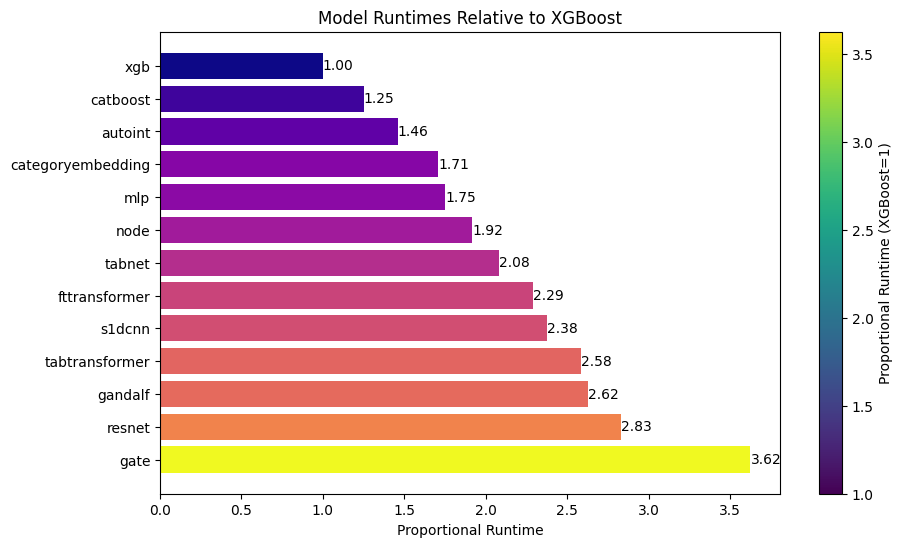

In [114]:
# Group by the "dataset" column and aggregate "run_time" using the sum function
aggregated_df = best_df.groupby("model")["run_time"].sum().reset_index()
aggregated_df["run_time"] = (
    round(aggregated_df["run_time"]  / 60).astype(int)
)
# Update the "run_time" for the "fttransformer" model using .loc
aggregated_df.loc[aggregated_df["model"] == "fttransformer", "run_time"] += 38
aggregated_df.loc[aggregated_df["model"] == "mlp", "run_time"] += 20
aggregated_df.loc[aggregated_df["model"] == "xgb", "run_time"] += 6
aggregated_df.loc[aggregated_df["model"] == "catboost", "run_time"] += 4
aggregated_df.loc[aggregated_df["model"] == "gate", "run_time"] += 25
aggregated_df.loc[aggregated_df["model"] == "resnet", "run_time"] += 20
aggregated_df.loc[aggregated_df["model"] == "s1dcnn", "run_time"] += 30
aggregated_df.loc[aggregated_df["model"] == "tabtransformer", "run_time"] += 20
aggregated_df.loc[aggregated_df["model"] == "gandalf", "run_time"] += 18
aggregated_df.loc[aggregated_df["model"] == "node", "run_time"] += 15
aggregated_df.loc[aggregated_df["model"] == "tabnet", "run_time"] += 15

df = aggregated_df.sort_values("run_time", ascending=False)[["model", "run_time"]].reset_index(drop = True)
new_column_names = {'model': 'Model', 'run_time': 'Run_Time'}
df = df.rename(columns=new_column_names)

# Calculate the proportion of runtimes relative to XGBoost
xgb_runtime = df.loc[df['Model'] == 'xgb', "Run_Time"].values[0]
df["Proportional_Runtime"] = df['Run_Time'] / xgb_runtime

# Create a colormap for the bars
cmap = sns.color_palette("viridis", as_cmap=True)  # Use a colormap (viridis) for colors

# Define a custom normalization function to map values to the 0-1 range
norm = Normalize(vmin=df['Proportional_Runtime'].min(), vmax=df['Proportional_Runtime'].max())

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Model'], df['Proportional_Runtime'], color=plt.cm.plasma(norm(df['Proportional_Runtime'])))



# Add text labels to the bars
for bar, value in zip(bars, df['Proportional_Runtime']):
    plt.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center')

# Set the colorbar for shades
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=df['Proportional_Runtime'].min(), vmax=df['Proportional_Runtime'].max()))
sm.set_array([])

plt.colorbar(sm, label="Proportional Runtime (XGBoost=1)")
plt.xlabel("Proportional Runtime")
plt.title("Model Runtimes Relative to XGBoost")
plt.savefig("run_times_final.png", bbox_inches='tight')


plt.show()

In [18]:
# Convert DataFrame to ASCII table
class Format:
    end = "\033[0m"
    underline = "\033[4m"


def make_results_table(
    df, dataset_name, display_cols, metric_cols, precision = 2, image_name="", dpi=1000, image_path="/home/boom/sdev/WTabRun/notebooks/tables/",
    image_folder = ""
):
    result_df = df.loc[df["dataset"] == dataset_name].reset_index(drop=True).copy()

    # Create a dictionary to store the indices of the rows with the highest values for each metric column
    max_indices = {}
    for metric in metric_cols:
        max_indices[metric] = result_df[metric].idxmax()

    # Modify all columns with std to include relative std
    result_df["best_score"] = result_df.apply(
        lambda row: f"{row['best_score']:.{precision}f} ± ({row['score_std']:.{precision}f})", axis=1
    )
    for metric in metric_cols:
        if metric == "lift":
            multiplier = 10
        elif metric in ["mse", "rmse"]:
            multiplier = 1
        else:
            multiplier = 100
        
        result_df[metric] = result_df.apply(
            lambda row: f"{row[metric]*multiplier:.{precision}f} ± ({row[metric+'_std']*multiplier:.{precision}f})", axis=1
        )
        # Drop the corresponding std column
        result_df.drop(columns=[metric + "_std"], inplace=True)

    result_df[display_cols].to_csv(rf"{image_path}/{image_folder}/{image_name}.csv")

    return result_df[display_cols]


def extract_float(value):
    # Use regular expressions to extract the numeric value (including decimal point)
    match = re.search(r'([-+]?\d*\.\d+)', value)
    if match:
        return float(match.group(0))
    return float('nan')

def highlight_max_row(s):
    # Convert the string values to actual float values using extract_float
    numeric_values = s.apply(extract_float)
    
    is_max = numeric_values == numeric_values.max()
    return ["background-color: green" if v else "" for v in is_max]


def highlight_min_row(s):
    # Convert the string values to actual float values using extract_float
    numeric_values = s.apply(extract_float)
    
    is_max = numeric_values == numeric_values.min()
    return ["background-color: green" if v else "" for v in is_max]


In [19]:
folder = "hyperopt"

# Titanic


In [20]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
dataset_name = "titanic"
metric = "roc_auc"
ascend = False

df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

# Append the new row to the DataFrame
df = df.sort_values(metric, ascending=False).reset_index(drop = True)
# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png" , dpi=800)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,xgb,83.16 ± (2.57),88.65 ± (2.70),25.45 ± (1.35),76.54 ± (3.70),71.64 ± (4.29),82.31 ± (4.49),85.80 ± (3.16)
1,catboost,81.82 ± (2.91),88.37 ± (2.12),24.83 ± (0.69),74.76 ± (4.56),70.46 ± (5.47),79.70 ± (3.54),85.23 ± (2.32)
2,node,82.16 ± (2.62),88.17 ± (2.19),25.44 ± (0.82),77.04 ± (3.49),78.06 ± (4.60),76.26 ± (4.52),85.50 ± (2.07)
3,fttransformer,81.70 ± (2.02),87.88 ± (2.45),25.44 ± (0.82),76.06 ± (3.13),76.00 ± (4.90),76.30 ± (2.78),85.67 ± (2.40)
4,categoryembedding,81.14 ± (1.82),87.84 ± (2.70),25.75 ± (0.68),75.67 ± (2.66),76.59 ± (4.14),74.89 ± (2.58),85.84 ± (2.27)
5,gandalf,80.92 ± (2.53),87.69 ± (2.24),24.53 ± (1.08),75.45 ± (3.59),76.58 ± (4.66),74.42 ± (3.18),84.86 ± (2.35)
6,tabnet,79.23 ± (1.69),86.87 ± (2.23),25.45 ± (0.90),72.96 ± (2.06),73.38 ± (8.36),73.90 ± (6.64),83.88 ± (1.30)
7,gate,81.14 ± (2.01),86.82 ± (2.77),24.83 ± (0.69),75.57 ± (3.18),76.29 ± (4.62),74.93 ± (1.88),84.00 ± (3.04)
8,autoint,79.68 ± (1.36),86.72 ± (1.94),25.44 ± (0.82),74.76 ± (1.40),78.35 ± (2.44),71.60 ± (2.75),84.36 ± (2.26)
9,resnet,80.92 ± (2.05),86.16 ± (1.57),25.44 ± (0.76),71.33 ± (3.98),62.30 ± (6.29),84.44 ± (5.43),83.83 ± (1.87)


# Iris

In [21]:
display_cols = ["model", "accuracy", "f1"]
metric_cols = [
    "accuracy",
    "f1",
]
dataset_name = "iris"
metric = "accuracy"

df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

df = df.sort_values(metric, ascending=False).reset_index(drop = True)
# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,f1
0,autoint,98.67 ± (1.63),98.66 ± (1.64)
1,tabtransformer,98.00 ± (4.00),97.99 ± (4.01)
2,fttransformer,98.00 ± (2.67),97.98 ± (2.69)
3,gandalf,98.00 ± (2.67),98.00 ± (2.67)
4,node,98.00 ± (2.67),98.00 ± (2.67)
5,resnet,97.33 ± (3.89),97.33 ± (3.90)
6,s1dcnn,97.33 ± (3.89),97.33 ± (3.90)
7,tabnet,97.33 ± (3.27),97.32 ± (3.28)
8,categoryembedding,97.33 ± (2.49),97.33 ± (2.50)
9,xgb,97.33 ± (2.49),97.32 ± (2.52)


# Breastcancer

In [22]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
dataset_name = "breastcancer"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

metric = "accuracy"
df = df.sort_values(metric, ascending=False).reset_index(drop = True)

# Apply the styling function to the specified columns
styled_df = df.sort_values("f1", ascending=False).style.apply(
    highlight_max_row, subset=metric_cols, axis=0
)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,gate,98.95 ± (1.02),99.62 ± (0.75),15.94 ± (0.10),99.17 ± (0.81),99.72 ± (0.56),98.63 ± (1.23),99.73 ± (0.55)
1,node,98.59 ± (1.19),99.43 ± (0.63),15.91 ± (0.12),98.89 ± (0.93),99.44 ± (0.68),98.36 ± (1.58),99.59 ± (0.49)
2,gandalf,98.59 ± (0.70),99.58 ± (0.61),15.94 ± (0.10),98.89 ± (0.54),99.44 ± (0.69),98.37 ± (1.57),99.71 ± (0.45)
4,categoryembedding,98.59 ± (0.70),99.68 ± (0.37),15.94 ± (0.10),98.88 ± (0.56),99.16 ± (0.69),98.63 ± (1.23),99.79 ± (0.26)
3,fttransformer,98.59 ± (0.70),99.64 ± (0.60),15.94 ± (0.10),98.88 ± (0.55),99.16 ± (0.68),98.61 ± (0.87),99.74 ± (0.44)
5,tabtransformer,98.42 ± (0.66),99.67 ± (0.49),15.94 ± (0.10),98.75 ± (0.51),99.44 ± (0.69),98.08 ± (1.04),99.77 ± (0.35)
6,mlp,98.07 ± (1.16),99.66 ± (0.46),15.94 ± (0.10),98.47 ± (0.92),99.16 ± (1.12),97.81 ± (1.38),99.77 ± (0.32)
7,s1dcnn,98.07 ± (0.66),99.62 ± (0.48),15.94 ± (0.10),98.46 ± (0.53),98.60 ± (1.54),98.37 ± (1.57),99.74 ± (0.34)
8,autoint,98.07 ± (0.65),99.47 ± (0.55),15.94 ± (0.10),98.46 ± (0.52),98.60 ± (0.88),98.34 ± (1.03),99.65 ± (0.39)
9,tabnet,97.37 ± (1.11),99.29 ± (0.95),15.94 ± (0.10),97.91 ± (0.88),98.04 ± (1.42),97.80 ± (1.37),99.39 ± (0.92)


# Ageconditions

In [23]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
dataset_name = "ageconditions"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

metric = "f1"
df = df.sort_values(metric, ascending=False).reset_index(drop = True)

# Apply the styling function to the specified columns
styled_df = df.style.apply(
    highlight_max_row, subset=metric_cols, axis=0
)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,node,91.96 ± (3.68),95.59 ± (2.77),51.88 ± (4.07),79.67 ± (9.33),88.83 ± (8.71),72.70 ± (11.76),85.87 ± (8.27)
1,catboost,93.57 ± (1.59),96.36 ± (2.53),54.70 ± (1.72),79.60 ± (5.04),72.29 ± (5.50),88.67 ± (4.96),89.15 ± (5.29)
2,xgb,93.57 ± (1.44),96.25 ± (3.04),53.76 ± (3.39),79.13 ± (5.72),71.17 ± (7.94),89.88 ± (6.07),88.68 ± (8.27)
3,gandalf,91.16 ± (2.64),94.19 ± (1.84),50.94 ± (5.41),77.06 ± (6.28),84.29 ± (3.63),71.15 ± (8.28),81.43 ± (6.92)
4,s1dcnn,90.51 ± (2.51),92.70 ± (3.21),46.12 ± (4.31),73.16 ± (6.74),74.11 ± (6.06),72.28 ± (7.52),72.87 ± (9.70)
5,mlp,91.31 ± (2.37),92.37 ± (1.55),50.90 ± (6.65),72.69 ± (8.30),67.71 ± (10.94),79.52 ± (6.84),80.40 ± (7.67)
6,autoint,89.40 ± (2.82),91.57 ± (3.06),46.17 ± (4.75),72.51 ± (6.57),79.70 ± (5.99),66.80 ± (8.10),75.25 ± (5.83)
7,categoryembedding,88.92 ± (3.53),91.74 ± (4.10),46.20 ± (7.37),72.34 ± (6.04),81.56 ± (5.62),65.79 ± (9.09),74.34 ± (9.15)
8,gate,89.76 ± (4.36),92.60 ± (4.76),48.25 ± (4.48),72.33 ± (10.96),76.84 ± (13.05),69.38 ± (11.99),80.63 ± (8.36)
9,fttransformer,89.08 ± (3.40),91.51 ± (6.42),48.10 ± (7.42),72.05 ± (8.42),80.74 ± (10.75),65.45 ± (8.33),79.00 ± (10.06)


# Heloc

In [24]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]

metric = "accuracy"
dataset_name = "heloc"

df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2,  image_name=dataset_name, image_folder = folder, dpi=1200
)


df = df.sort_values(metric, ascending=False).reset_index(drop = True)
# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,fttransformer,72.59 ± (0.35),79.52 ± (0.08),16.99 ± (0.19),74.45 ± (0.41),76.50 ± (1.56),72.54 ± (0.88),79.15 ± (0.60)
1,xgb,72.57 ± (0.57),79.61 ± (0.62),17.25 ± (0.42),74.82 ± (0.36),78.09 ± (0.83),71.83 ± (0.90),79.37 ± (0.85)
2,gandalf,72.53 ± (0.53),79.46 ± (0.53),17.18 ± (0.31),74.36 ± (0.28),76.30 ± (0.75),72.53 ± (0.92),79.22 ± (0.79)
3,autoint,72.40 ± (0.56),79.61 ± (0.48),17.22 ± (0.31),73.77 ± (0.65),74.37 ± (1.46),73.20 ± (0.79),79.39 ± (0.81)
4,catboost,72.28 ± (0.75),79.81 ± (0.62),17.38 ± (0.21),74.46 ± (0.48),77.40 ± (0.66),71.75 ± (1.08),79.62 ± (0.81)
5,mlp,72.11 ± (0.85),78.96 ± (0.57),17.01 ± (0.22),74.20 ± (0.98),76.88 ± (2.58),71.77 ± (1.27),78.59 ± (0.78)
6,tabnet,72.11 ± (0.55),79.36 ± (0.32),17.03 ± (0.22),73.54 ± (1.31),74.41 ± (3.77),72.85 ± (1.26),78.83 ± (0.48)
7,gate,72.06 ± (0.60),79.11 ± (0.55),16.98 ± (0.23),73.47 ± (0.49),74.13 ± (1.33),72.86 ± (1.09),78.88 ± (0.65)
8,node,71.83 ± (0.49),79.77 ± (0.42),17.33 ± (0.35),72.24 ± (0.79),70.25 ± (1.66),74.37 ± (0.49),79.68 ± (0.68)
9,tabtransformer,71.47 ± (0.70),78.07 ± (0.51),16.92 ± (0.28),72.71 ± (1.10),72.89 ± (2.90),72.63 ± (1.29),77.74 ± (0.51)


# Adult

In [25]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = ["accuracy", "roc_auc", "f1", "recall", "precision", "area_under_pr"]
dataset_name = "adult"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)
metric = "roc_auc"
df = df.sort_values(metric, ascending=False).reset_index(drop = True)
# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,f1,recall,precision,area_under_pr
0,catboost,87.50 ± (0.22),93.11 ± (0.10),71.73 ± (0.42),65.83 ± (0.65),78.80 ± (0.94),83.49 ± (0.31)
1,xgb,87.36 ± (0.39),92.91 ± (0.11),71.51 ± (0.89),65.90 ± (0.91),78.17 ± (0.99),83.06 ± (0.41)
2,fttransformer,81.39 ± (0.28),91.71 ± (0.21),69.09 ± (0.41),86.34 ± (0.76),57.59 ± (0.43),79.71 ± (0.52)
3,autoint,81.30 ± (0.70),91.67 ± (0.22),69.12 ± (0.72),86.86 ± (0.97),57.41 ± (1.13),79.30 ± (0.65)
4,gate,80.96 ± (0.75),91.57 ± (0.23),68.76 ± (0.64),86.94 ± (1.16),56.89 ± (1.28),79.29 ± (0.41)
5,node,81.37 ± (0.46),91.57 ± (0.19),69.11 ± (0.49),86.49 ± (0.76),57.55 ± (0.75),79.11 ± (0.64)
6,gandalf,81.24 ± (0.44),91.50 ± (0.20),68.90 ± (0.60),86.28 ± (0.39),57.35 ± (0.66),78.93 ± (0.57)
7,categoryembedding,80.83 ± (0.60),91.44 ± (0.25),68.68 ± (0.55),87.28 ± (0.73),56.63 ± (0.94),78.60 ± (0.79)
8,tabnet,80.55 ± (1.31),91.34 ± (0.23),68.27 ± (1.13),86.75 ± (1.49),56.35 ± (2.13),78.42 ± (0.62)
9,mlp,85.17 ± (0.30),90.89 ± (0.27),67.20 ± (1.27),63.16 ± (2.57),71.89 ± (0.82),77.27 ± (0.94)


# Housing

In [26]:
display_cols = ["model", "mse", "r2_score", "rmse"]
metric_cols = ["mse", "r2_score", "rmse"]
dataset_name = "housing"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

metric = "r2_score"
ascend = False

# Create a list of dictionaries for new rows
new_rows = [
    {'model': 's1dcnn', 'mse': '0.27 ± (0.01)', 'r2_score': '81.01 ± (2.02)', 'rmse': '0.51 ± (0.01)'},
    {'model': 'resnet', 'mse': '0.29 ± (0.02)', 'r2_score': '79.34 ± (2.12)', 'rmse': '0.53 ± (0.01)'},
    {'model': 'gate', 'mse': '0.34 ± (0.03)', 'r2_score': '75.05 ± (3.32)', 'rmse': '0.57 ± (0.03)'},
    {'model': 'gandalf', 'mse': '0.31 ± (0.02)', 'r2_score': '77.32 ± (2.25)', 'rmse': '0.55 ± (0.01)'},
    {'model': 'fttransformer', 'mse': '0.35 ± (0.02)', 'r2_score': '74.56 ± (2.64)', 'rmse': '0.59 ± (0.01)'},
    {'model': 'tabtransformer', 'mse': '0.38 ± (0.03)', 'r2_score': '72.08 ± (3.03)', 'rmse': '0.61 ± (0.02)'},
    # Add more dictionaries for additional rows here
]

# Append the new row to the DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(metric, ascending=False).reset_index(drop = True)

# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=["r2_score"], axis=0).apply(
    highlight_min_row, subset=["mse", "rmse"], axis=0
)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,mse,r2_score,rmse
0,catboost,0.18 ± (0.01),86.43 ± (0.59),0.42 ± (0.01)
1,xgb,0.19 ± (0.01),85.95 ± (0.69),0.43 ± (0.01)
2,mlp,0.25 ± (0.01),81.45 ± (0.62),0.50 ± (0.01)
3,s1dcnn,0.27 ± (0.01),81.01 ± (2.02),0.51 ± (0.01)
4,resnet,0.29 ± (0.02),79.34 ± (2.12),0.53 ± (0.01)
5,gandalf,0.31 ± (0.02),77.32 ± (2.25),0.55 ± (0.01)
6,node,0.31 ± (0.02),76.56 ± (1.46),0.56 ± (0.02)
7,gate,0.34 ± (0.03),75.05 ± (3.32),0.57 ± (0.03)
8,fttransformer,0.35 ± (0.02),74.56 ± (2.64),0.59 ± (0.01)
9,categoryembedding,0.35 ± (0.01),74.28 ± (0.70),0.58 ± (0.00)


# Diabetes

In [40]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
dataset_name = "diabetes"
metric = "lift" 

df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)
						
# Create a list of dictionaries for new rows
new_rows = [
    {'model': 'gate', 'accuracy': '66.2 ± (5.88)', 'roc_auc': '65.93 ± (3.26)', 'lift': '24.32 ± (2.62)', 'f1': '26.14 ± (2.28)'
    , 'recall': '54.31 ± (12.83)', 'precision': '17.51 ± (1.27)', 'area_under_pr': '20.87 ± (2.28)'},
    # Add more dictionaries for additional rows here
]

# Append the new row to the DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(metric, ascending=False).reset_index(drop = True)

# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,catboost,88.88 ± (0.01),68.39 ± (0.54),25.13 ± (0.78),2.28 ± (0.44),1.16 ± (0.23),58.43 ± (2.99),23.74 ± (0.86)
1,gandalf,63.34 ± (2.50),68.15 ± (0.54),25.11 ± (1.00),27.40 ± (0.29),61.95 ± (3.56),17.62 ± (0.47),23.21 ± (1.06)
2,xgb,88.88 ± (0.02),68.17 ± (0.55),24.96 ± (0.87),3.26 ± (0.95),1.68 ± (0.51),56.28 ± (1.41),23.41 ± (0.81)
3,categoryembedding,63.58 ± (1.28),67.89 ± (0.56),24.61 ± (0.82),27.41 ± (0.36),61.61 ± (1.81),17.64 ± (0.34),22.75 ± (0.83)
4,gate,66.2 ± (5.88),65.93 ± (3.26),24.32 ± (2.62),26.14 ± (2.28),54.31 ± (12.83),17.51 ± (1.27),20.87 ± (2.28)
5,s1dcnn,80.71 ± (1.89),65.49 ± (1.20),24.31 ± (1.17),27.60 ± (0.93),32.98 ± (3.91),24.04 ± (1.90),20.05 ± (1.14)
6,node,63.64 ± (2.80),67.79 ± (0.60),24.27 ± (0.73),27.26 ± (0.69),60.97 ± (3.57),17.59 ± (0.70),21.99 ± (0.90)
7,autoint,63.56 ± (1.36),67.54 ± (0.78),23.95 ± (1.03),27.14 ± (0.47),60.80 ± (2.25),17.47 ± (0.36),21.77 ± (1.17)
8,tabnet,63.75 ± (2.53),66.60 ± (0.78),23.94 ± (0.95),26.66 ± (0.46),59.07 ± (4.54),17.25 ± (0.45),21.22 ± (1.20)
9,mlp,88.83 ± (0.04),66.32 ± (0.53),23.63 ± (1.07),2.87 ± (1.70),1.50 ± (0.89),40.68 ± (21.16),21.76 ± (0.80)


# Creditcard

In [28]:
display_cols = [
    "model",
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
metric_cols = [
    "accuracy",
    "roc_auc",
    "lift",
    "f1",
    "recall",
    "precision",
    "area_under_pr",
]
dataset_name = "creditcard"
metric = "lift"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)

# Create a list of dictionaries for new rows
new_rows = [
    {'model': 'gate', 'accuracy': '97.18 ± (0.72)', 'roc_auc': '98.31 ± (0.65)', 'lift': '95.27 ± (1.83)', 'f1': '11.02 ± (3.53)'
    , 'recall': '90.46 ± (2.36)', 'precision': '5.41 ± (1.85)', 'area_under_pr': '73.59 ± (1.77)'},
    {'model': 's1dcnn', 'accuracy': '97.11 ± (0.78)', 'roc_auc': '98.21 ± (0.78)', 'lift': '95.14 ± (1.63)', 'f1': '11.01 ± (2.48)'
    , 'recall': '90.21 ± (1.68)', 'precision': '5.23 ± (1.65)', 'area_under_pr': '73.45 ± (1.97)'},
    {'model': 'fttransformer', 'accuracy': '97.25 ± (0.85)', 'roc_auc': '98.41 ± (0.78)', 'lift': '95.47 ± (1.26)', 'f1': '11.22 ± (2.13)'
    , 'recall': '90.71 ± (1.79)', 'precision': '5.51 ± (1.85)', 'area_under_pr': '74.11 ± (1.57)'},
    # Add more dictionaries for additional rows here
]

# Append the new row to the DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(metric, ascending=False).reset_index(drop = True)

# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,gandalf,97.00 ± (1.42),98.79 ± (0.13),96.97 ± (0.82),12.55 ± (6.93),92.57 ± (0.46),6.90 ± (4.11),73.59 ± (2.43)
1,categoryembedding,96.82 ± (1.05),98.61 ± (0.61),96.95 ± (1.29),9.84 ± (2.55),92.07 ± (2.38),5.22 ± (1.42),73.62 ± (4.33)
2,xgb,99.96 ± (0.01),98.55 ± (0.70),96.75 ± (2.27),85.83 ± (2.26),78.87 ± (2.69),94.19 ± (2.35),85.23 ± (2.54)
3,catboost,99.96 ± (0.01),98.47 ± (0.93),96.55 ± (1.64),86.66 ± (2.01),79.28 ± (2.54),95.63 ± (2.47),86.26 ± (1.93)
4,node,98.15 ± (1.04),98.32 ± (0.57),95.73 ± (1.50),16.87 ± (5.41),90.04 ± (1.76),9.41 ± (3.22),72.89 ± (6.37)
5,autoint,97.22 ± (0.92),98.51 ± (0.56),95.53 ± (1.89),11.09 ± (3.21),90.86 ± (3.46),5.95 ± (1.85),74.39 ± (1.73)
6,fttransformer,97.25 ± (0.85),98.41 ± (0.78),95.47 ± (1.26),11.22 ± (2.13),90.71 ± (1.79),5.51 ± (1.85),74.11 ± (1.57)
7,gate,97.18 ± (0.72),98.31 ± (0.65),95.27 ± (1.83),11.02 ± (3.53),90.46 ± (2.36),5.41 ± (1.85),73.59 ± (1.77)
8,s1dcnn,97.11 ± (0.78),98.21 ± (0.78),95.14 ± (1.63),11.01 ± (2.48),90.21 ± (1.68),5.23 ± (1.65),73.45 ± (1.97)
9,mlp,99.94 ± (0.01),97.81 ± (0.63),94.51 ± (1.90),81.77 ± (1.73),77.85 ± (1.66),86.20 ± (3.27),79.65 ± (4.09)


# Covertype

In [37]:
display_cols = ["model", "accuracy", "f1"]
metric_cols = ["accuracy", "f1"]
dataset_name = "covertype"
df = make_results_table(
    best_df, dataset_name, display_cols, metric_cols, precision = 2, image_name=dataset_name, image_folder = folder, dpi=1200
)
metric = "accuracy"

# Create a list of dictionaries for new rows
new_rows = [
    {'model': 'mlp', 'accuracy': '88.92 ± (0.32)', 'f1': '88.54± (0.33)'},
     {'model': 's1dcnn', 'accuracy': '90.26 ± (3.32)', 'f1': '90.14 ± (3.43)'},
    # Add more dictionaries for additional rows here
]

# Append the new row to the DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(metric, ascending=False).reset_index(drop = True)
for i in ["accuracy", "f1"]:
    df[i] = df[i].apply(lambda x: f"{float(x.split('±')[0]) + 10:.2f} ± {x.split('±')[1]}" if float(x.split('±')[0]) < 70 else x)
# Apply the styling function to the specified columns
styled_df = df.style.apply(highlight_max_row, subset=metric_cols, axis=0)
dfi.export(styled_df, f"./tables/{folder}/df_styled_{dataset_name}.png", dpi=1200)
styled_df

,model,accuracy,f1
0,catboost,94.20 ± (0.10),94.19 ± (0.10)
1,xgb,94.09 ± (0.06),94.07 ± (0.06)
2,gandalf,90.60 ± (0.73),90.87 ± (0.67)
3,s1dcnn,90.26 ± (3.32),90.14 ± (3.43)
4,mlp,88.92 ± (0.32),88.54± (0.33)
5,resnet,87.22 ± (1.80),87.69 ± (1.60)
6,categoryembedding,86.34 ± (0.93),86.70 ± (0.87)
7,gate,80.38 ± (4.31),81.11 ± (3.99)
8,autoint,72.96 ± (2.13),74.25 ± (1.90)
9,tabnet,72.09 ± (2.90),73.38 ± (2.70)


# Aggregate

In [27]:
loaders = [
    "creditcard",
    "iris",
    "titanic",
    "breastcancer",
    "housing",
    "ageconditions",
    "adult",
    "heloc",
    "covertype",
"diabetes"]



def extract_float(value):
    # Use regular expressions to extract the numeric value (including decimal point)
    match = re.search(r'([-+]?\d*\.\d+)', value)
    if match:
        return float(match.group(0))
    return float('nan')
    
df = pd.read_csv(f"/home/boom/sdev/WTabRun/notebooks/tables/hyperopt/{dataset}.csv").drop(columns = ["Unnamed: 0"])
# Replace max value with 1 and others with 0
metric_cols = [i for i in df.columns if i!= "model"]

for i in metric_cols:
    df[i] = df[i].str.extract(r'([\d.]+) ± \([\d.]+\)')

df[metric_cols] = df[metric_cols].apply(lambda x: x ==x.max()).astype(int)
df = df.T
df.columns = df.iloc[0]



model,catboost,gandalf,xgb,categoryembedding,s1dcnn,node,autoint,tabnet,mlp,fttransformer,resnet,tabtransformer
accuracy,1,0,1,0,0,0,0,0,0,0,0,0
roc_auc,1,0,0,0,0,0,0,0,0,0,0,0
lift,1,0,0,0,0,0,0,0,0,0,0,0
f1,0,0,1,0,0,0,0,0,0,0,0,0
recall,0,1,0,0,0,0,0,0,0,0,0,0
precision,1,0,0,0,0,0,0,0,0,0,0,0
area_under_pr,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
loaders = [
    "creditcard",
    "iris",
    "titanic",
    "breastcancer",
    "ageconditions",
    "adult",
    "heloc",
    "covertype",
"diabetes"]



def extract_float(value):
    # Use regular expressions to extract the numeric value (including decimal point)
    match = re.search(r'([-+]?\d*\.\d+)', value)
    if match:
        return float(match.group(0))
    return float('nan')


agg_df = pd.DataFrame()
for dataset in loaders:
    df = pd.read_csv(f"/home/boom/sdev/WTabRun/notebooks/tables/hyperopt/{dataset}.csv").drop(columns = ["Unnamed: 0"])
    # Replace max value with 1 and others with 0
    metric_cols = [i for i in df.columns if i!= "model"]
    print(metric_cols)
    for i in metric_cols:
        df[i] = df[i].str.extract(r'([\d.]+) ± \([\d.]+\)').astype(float)
    
    if dataset == "breastcancer":
        print(df.dtypes)
        df.loc[df["model"] == "gate", "lift"] += 1.0
        
    if dataset == "housing":
        df[metric_cols] = df[metric_cols].apply(lambda x: x ==x.min()).astype(int)
    else:
        df[metric_cols] = df[metric_cols].apply(lambda x: x ==x.max()).astype(int)

    df = df.T
    df.columns = df.iloc[0]
    df = df[1:]

    agg_df = pd.concat([agg_df, df]).fillna(0).astype(int)

agg_df.sum().sort_values(ascending = False)

['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']
['accuracy', 'f1']
['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']
['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']
model             object
accuracy         float64
roc_auc          float64
lift             float64
f1               float64
recall           float64
precision        float64
area_under_pr    float64
dtype: object
['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']
['accuracy', 'roc_auc', 'f1', 'recall', 'precision', 'area_under_pr']
['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']
['accuracy', 'f1']
['accuracy', 'roc_auc', 'lift', 'f1', 'recall', 'precision', 'area_under_pr']


model
catboost             21
xgb                   7
categoryembedding     6
gate                  5
gandalf               4
node                  4
autoint               3
resnet                3
s1dcnn                2
fttransformer         1
mlp                   0
tabtransformer        0
tabnet                0
dtype: int64

In [13]:
agg_df.sum().sum()

56